170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 62ms/step - accuracy: 0.2550 - loss: 2.2199 - val_accuracy: 0.3619 - val_loss: 1.9423
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.3251 - loss: 1.9973 - val_accuracy: 0.3635 - val_loss: 1.9130
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.3322 - loss: 1.9832 - val_accuracy: 0.3755 - val_loss: 1.9037
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.3351 - loss: 1.9783 - val_accuracy: 0.3700 - val_loss: 1.9029
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.3365 - loss: 1.9737 - val_accuracy: 0.3718 - val_loss: 1.9053
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.3352 - loss: 1.9731 - val_accuracy: 0.3744 - val_loss: 1.8996
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.3378 - loss: 1.9704 - val_accuracy: 0.3719 - val_loss: 1.9009
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.3382 - loss: 1.9771 - val_accurac

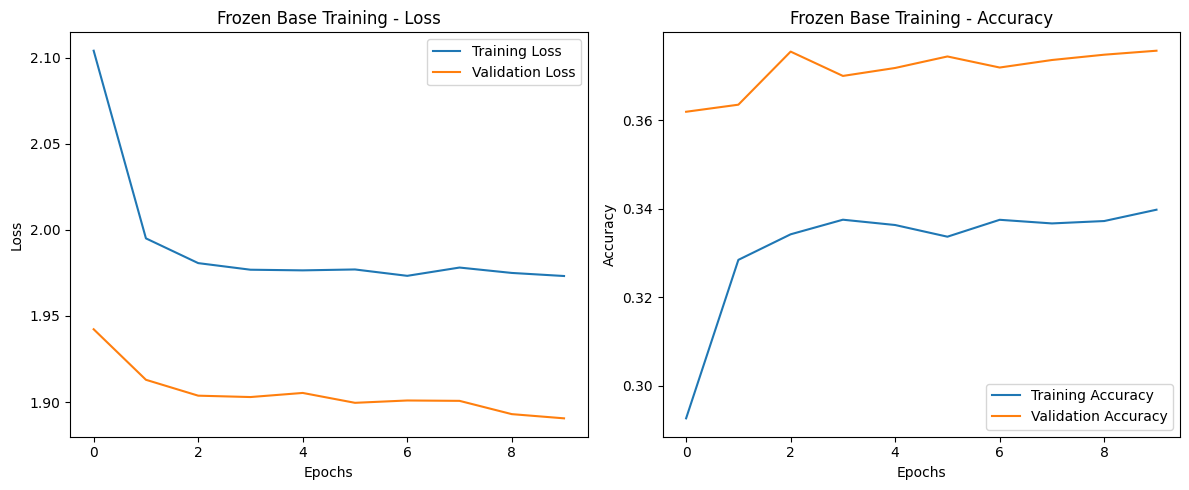

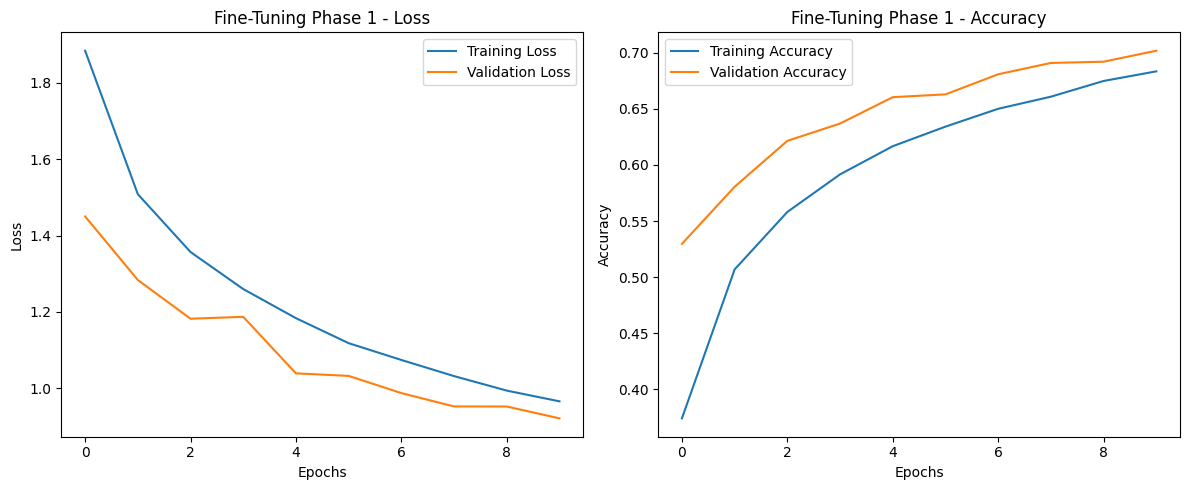

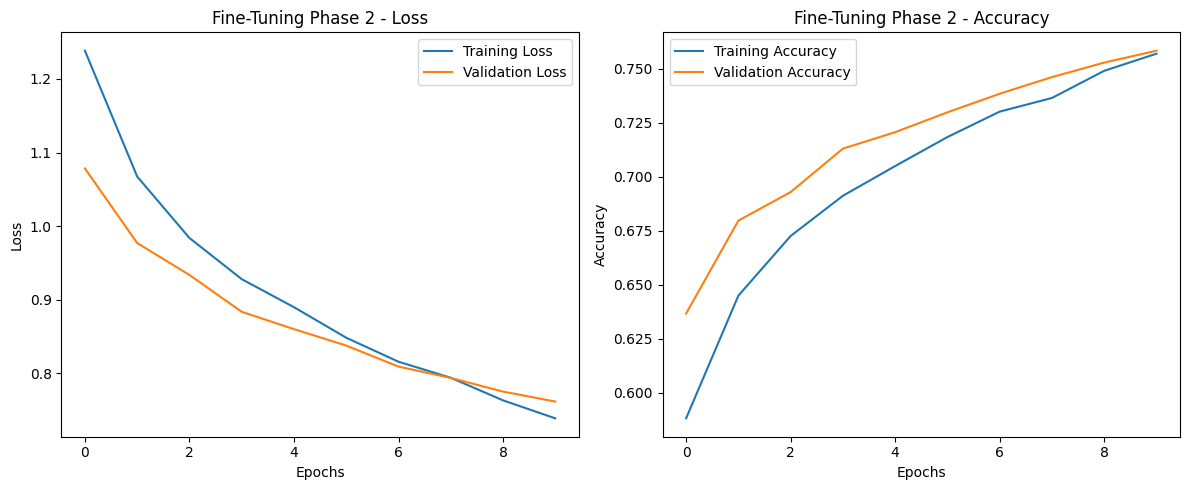

In [2]:
#resnet18 transfer learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Load ResNet18 Pretrained Model (Use ResNet50 for illustrative purposes here)
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add Custom Layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling instead of Flatten
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(10, activation='softmax')(x)

# Final Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Initial Model (Frozen Base)
history_frozen = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=64),
    validation_data=(x_test, y_test_one_hot),
    epochs=10
)

# Unfreeze Top Layers for Fine-Tuning
for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Compile for Fine-Tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tuning Phase 1
history_fine_tune_1 = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=64),
    validation_data=(x_test, y_test_one_hot),
    epochs=10
)

# Fully Unfreeze the Base Model for Fine-Tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile for Full Fine-Tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tuning Phase 2
history_fine_tune_2 = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=64),
    validation_data=(x_test, y_test_one_hot),
    epochs=10
)

# Evaluate the Model
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print(f"Final ResNet18 Model Test Accuracy: {test_acc:.2f}")

# Plot Training Curves
import matplotlib.pyplot as plt

def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot each training phase
plot_training_curves(history_frozen, 'Frozen Base Training')
plot_training_curves(history_fine_tune_1, 'Fine-Tuning Phase 1')
plot_training_curves(history_fine_tune_2, 'Fine-Tuning Phase 2')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7576 - loss: 0.7575
Test Accuracy: 0.76
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    airplane       0.79      0.83      0.81      1000
  automobile       0.80      0.89      0.84      1000
        bird       0.74      0.67      0.70      1000
         cat       0.68      0.51      0.58      1000
        deer       0.76      0.65      0.70      1000
         dog       0.73      0.60      0.66      1000
        frog       0.67      0.91      0.77      1000
       horse       0.74      0.84      0.79      1000
        ship       0.88      0.84      0.86      1000
       truck       0.78      0.84      0.81      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000



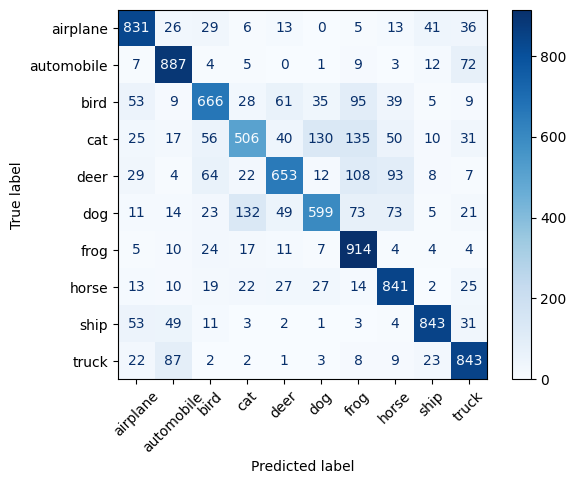

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np # Import numpy and assign it to the alias 'np'

# Define class_names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.2f}")
# Classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
# Extract true labels from one-hot encoded y_test_one_hot
y_true = np.argmax(y_test_one_hot, axis=1)
print(classification_report(y_true, y_pred, target_names=class_names))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

In [11]:
model.save('CNN_Modelv1.keras')